### 1\. Conversion bin - hex - dec
Write a function that converts numbers among the bin, dec, and hex representations (bin<->dec<->hex)

In [10]:
def convert(x):
    return [x, bin(x), hex(x)] #print automatically cast in base 10

# 0b for bin, 0x for hex, nothing for decimals in order to remove the ambiguity
print(convert(110)) #decimal input
print(convert(0b110)) #binary input
print(convert(0x110)) #hexadecimal input

[110, '0b1101110', '0x6e']
[6, '0b110', '0x6']
[272, '0b100010000', '0x110']


### 2\. 32 bit to float
Write a function that converts a 32 bit word into a single precision floating point (i.e. interprets the various bits as sign, mantissa and exponent) and check its validity.

In [11]:
x = "01000000111010000000000000000000"

# using pack struct
import struct
print("using struct: ", struct.unpack('!f',struct.pack('!I', int(x, 2)))[0])

# parsing manually from binary
def bin_2_float(f): 
    mantissa=1
    #Mantissa's formula
    for m,n in zip(f[9:32], range(1,len(f[9:32]))):
        mantissa+=int(m)*2**(-n) 
    sign = int(f[0],2)
    exp=int(f[-31:-23],2)-127
    
    return (-1)**sign * 2**exp * mantissa


print("parsing the string directly:", bin_2_float(x)) 

using struct:  7.25
parsing the string directly: 7.25


### 3\. Underflow/overflow determination

Write a program to determine the underflow and overflow limits (within a factor of 2) for python on your computer. 

**Tip**: define two variables initialized to 1 and halve/double them for a sufficient amount of times to exceed the under/over-flow limits  

In [74]:
x,y,z=1e0,1e0,1e0

#Python set the overflow to inf and underflow to 0
while x*2!=float("inf"): x*=2
print("The overflow estimation within a factor 2 is",x)

# Found out that the so-called "Denormal numbers" extended the underfow to e-324
while y/2!=0: y/=2
print("The underflow estimation WITH DENORMAL NUMBERS is",y)

# The correct underflow estimation can be done considering the inverse
while 2/z!=float("inf"): z/=2
print("The 'correct' underflow estimation within a factor 2 is",z)

# Checking the range automatically
import sys
print("\n",sys.float_info)

The overflow estimation within a factor 2 is 8.98846567431158e+307
The underflow estimation WITH DENORMAL NUMBERS is 5e-324
The 'correct' underflow estimation within a factor 2 is 1.1125369292536007e-308

 sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)


### 4\. Machine precision
Write a program to determine the machine precision

**Tip**: define a new variable by adding an increasingly smaller value (in the same way as the previous problem) and check when the addition starts to have no effect on the number

In [5]:
e,x=1,1
while (x+e/2)!=x:
    e/=2
    x+=e

print("The machine precision within a factor 2 is",e/x)
#The absolute precision depends on the observed value x, in the way that the relative precision is more or less constant

The machine precision within a factor 2 is 5.551115123125783e-17


### 5\. Second order equations
Write a function that takes in input three parameters $a$, $b$ and $c$ and prints out the two solutions to the quadratic equation $ax^2+bx+c=0$ using the standard formula:
$$
x=\frac{-b\pm\sqrt{b^2-4ac}}{2a}
$$

(a) use the program to compute the solution for $a=0.001$, $b=1000$ and $c=0.001$

(b) re-express the standard solution formula by multiplying the numerator and the denominator by $-b\mp\sqrt{b^2-4ac}$ and again find the solution for $a=0.001$, $b=1000$ and $c=0.001$. How does it compare with what has been previously obtained, and why?

(c) write a function that computes the roots of a quadratic equation accurately in all cases

Let's define:

$$x1 =\frac{-b + \sqrt{b^{2}-4 a c}}{2 a}$$,

$$x2 =\frac{-b - \sqrt{b^{2}-4 a c}}{2 a}$$

and for the second method

$$y1 =\frac{2 c}{-b - \sqrt{b^{2}-4 a c}}$$,

$$y2 =\frac{2 c}{-b + \sqrt{b^{2}-4 a c}}$$

In [48]:
# Unstable algorithm
from math import sqrt

def root_unstable(a,b,c):
    d2=b**2-4*a*c 
    # method a
    x1=(-b+sqrt(d2))/(2*a)
    x2=(-b-sqrt(d2))/(2*a)
    # method b 
    y1=2*c/(-b-sqrt(d2))
    y2=2*c/(-b+sqrt(d2))
    return [x1,x2,y1,y2]

sol = root_unstable(0.001,1000,0.001)
print("First method: {0}, {1}\nSecond method: {2}, {3}".format(*sol))
print("\nThe differences of correspondent solutions in the two algorithm are: %.11f, %.11f" % (sol[0]-sol[2], sol[1]-sol[3]))

First method: -9.999894245993346e-07, -999999.999999
Second method: -1.000000000001e-06, -1000010.5755125057

The differences of correspondent solutions in the two algorithm are: 0.00000000001, 10.57551350573


This algorithm is unstable because it amplifies the approximation error introduced by the finite precision on the $sqrt$ operation. 

In particular, let's focus on the following terms for the given values of $a,b,c$

$$d^{(+)} :=-b+\sqrt{b^2-4ac}\simeq -\mathcal{O}(10^3)+\mathcal{O}(10^3) \rightarrow 0$ when $b>>ac$$,

$$d^{(-)} :=-b-\sqrt{b^2-4ac}\simeq -\mathcal{O}(10^3)-\mathcal{O}(10^3)$$

Therefore, the first term is more affected by the round-off error introduced by the $sqrt$ since $\sqrt{b^2-4ac}\simeq b$. On the other hand, the second term is just fine, of $\mathcal{O}(10^3)$.

Since $d^{(+)}$ is only used to compute ```x1``` and ```y2```, a simple solution in order to stabilise the algorithm is to "merge" the two algorithm and consider only the solution that use just the $d^{(-)}$, so ```x2``` and ```y1```

In [46]:
def root_stable(a,b,c):
    d2=b**2-4*a*c 
    # from method a
    x2=(-b-sqrt(d2))/(2*a)
    # from method b 
    y1=2*c/(-b-sqrt(d2))
    return [x2,y1]

print( "Solution with the stable algorithm: {0}\t{1}".format(*root_stable(0.001,1000,0.001)) ) 

Solution with the stable algorithm: -999999.999999	-1.000000000001e-06


### 6\. Errors on Derivatives

Write a program that implements the function $f(x)=x(x−1)$

(a) Calculate the derivative of the function at the point $x = 1$ using the derivative definition:

$$
\frac{{\rm d}f}{{\rm d}x} = \lim_{\delta\to0} \frac{f(x+\delta)-f(x)}{\delta}
$$

with $\delta = 10^{−2}$. Calculate the true value of the same derivative analytically and compare it with the answer your program gives. The two will not agree perfectly. Why?

(b) Repeat the calculation for $\delta = 10^{−4}, 10^{−6}, 10^{−8}, 10^{−10}, 10^{−12}$ and $10^{−14}$. How does the accuracy scales with $\delta$?

In [47]:
def derivative(f, x, d): return (f(x+d)-f(x))/d

for i in range(2,16,2):
    d=10**(-i)
    deriv=derivative(lambda x:x**2-x,1,d)
    print("f'(1)=%.10f\tdelta: %1.e \taccuracy: %1.2e" % (deriv,d, deriv-1))

f'(1)=1.0100000000	delta: 1e-02 	accuracy: 1.00e-02
f'(1)=1.0001000000	delta: 1e-04 	accuracy: 1.00e-04
f'(1)=1.0000010000	delta: 1e-06 	accuracy: 1.00e-06
f'(1)=0.9999999939	delta: 1e-08 	accuracy: -6.08e-09
f'(1)=1.0000000827	delta: 1e-10 	accuracy: 8.27e-08
f'(1)=1.0000889006	delta: 1e-12 	accuracy: 8.89e-05
f'(1)=0.9992007222	delta: 1e-14 	accuracy: -7.99e-04



Analitically
$$
f'(x)=2\ x - 1 \rightarrow f'(1)=1
$$

For a finite $\delta$, the discretization error on the incremental ratio is of $\mathcal{O}(\delta^2)$. Indeed, from the Taylor expansion, 
    
$$
f(x+\delta)=f(x)+f'(x) \ \delta + \mathcal{O}(\delta^2) \ \rightarrow f'(x) = \frac{f(x+\delta)-f(x)}{\delta} + \mathcal{O}(\delta^2)
$$    
    

   

Text(0.5, 0, '$log_{10}(\\delta)$')

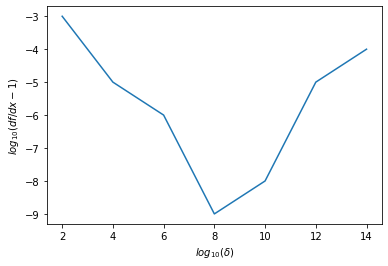

In [50]:
#Accuracy's order of magnitude as function of delta's order of magnitude
from math import log10, floor
import matplotlib.pyplot as plt

def find_exp(number):
    base10 = log10(abs(number))
    return floor(log10(abs(number)))

#y cointain the exponent of differences from f' and 1
y=[find_exp(derivative(lambda x:x**2-x,1,10**(-i))-1) for i in range(2,16,2)]
plt.plot(range(2,16,2), y)
plt.ylabel('$log_{10}(df/dx-1)$')
plt.xlabel('$log_{10}(\delta)$')


When $\delta$ becomes smaller and smaller the discretization error decreases. But on the other hand the round-off error is increased because we overcome the machine precision. This behaviour presents a minimum at which the evaluation reaches the best precision, around $\delta\simeq\mathcal{O}(10^{-8})$  


### 7\. Integral of the semicircle
Consider the integral of the semicircle of radius 1:
$$
I=\int_{-1}^{1} \sqrt(1-x^2) {\rm d}x
$$
which is known to be $I=\frac{\pi}{2}=1.57079632679...$.

Alternatively we can use the Riemann definition of the integral:
$$
I=\lim_{N\to\infty} \sum_{k=1}^{N} h y_k 
$$

with $h=2/N$ the width of each of the $N$ slices the domain is divided into and where
$y_k$ is the value of the function at the $k-$th slice.

(a) Write a program to compute the integral with $N=100$. How does the result compare to the true value?

(b) How much can $N$ be increased if the computation needs to be run in less than a second? What is the gain in running it for 1 minute? 


In [51]:
import numpy as np
import math as m
import time

def halfpi(N):
    I=0
    for k in np.linspace(-1,1,N):
        I+=2/N*m.sqrt(1-k**2)
    return I

print("The integral evaluated numerically with N=100 returns: %1.5f, while the true value is: %1.5f\nThe difference is: %0.5f" % (halfpi(100),m.pi/2,halfpi(100)-m.pi/2))

exe_time=0
i=100000 #Starting from 1e5, since we expect an high value of i
while exe_time<=1:
    start_time = time.time()
    halfpi(i)
    exe_time = time.time() - start_time
    i*=2
    print("--- %.2e --- %.5f seconds" % (i,(time.time() - start_time)))
    
print("The highest N (within a factor 2) that keeps the execution time below 1 sec is %.2e [exe time %.5f sec]\nThe difference with N=%.2e is %.5e" % (i/2,exe_time,i/2, halfpi(int(i/2))-m.pi/2) )


The integral evaluated numerically with N=100 returns: 1.55342, while the true value is: 1.57080
The difference is: -0.01738
--- 2.00e+05 --- 0.13961 seconds
--- 4.00e+05 --- 0.20497 seconds
--- 8.00e+05 --- 0.46160 seconds
--- 1.60e+06 --- 0.85121 seconds
--- 3.20e+06 --- 1.62154 seconds
The highest N (within a factor 2) that keeps the execution time below 1 sec is 1.60e+06 [exe time 1.62153 sec]
The difference with N=1.60e+06 is -9.82569e-07
